# Principle Component Analysis (PCA)

Principle Component Analysis (PCA) is an algorithm for dimensionality reduction. When we have a feature vector describing a data point, we can think of each feature being an orthogonal (perpendicular) axis on a plot. 

PCA computes new axes as a linear combination of the existing axes and re-orients (or projects) the data onto these new axes.

 - These new axes are called Principle Components (PC)
 - They are also a set of orthogonal axes.
 - The first PC is in the direction in which the data varies most. 
  - The second PC is perpendicular to the first and points in the direction the data varies second-most. 
  - The third PC is perpendicular to the first 2 and points in the direction the data varies third-most.
 - The PCs are ordered by importance. Their importance is quantified by a Singular Value.

Because the PCs are ordered by their explanatory power, we can keep just a few and discard the less informative features.

Let's look at an example.

### Example

Lets revisit the Palmer's Penguins dataset. Suppose we only had measurements of the bill to work with (length and depth).

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.datasets import make_blobs


In [2]:
ncenters = 4
label_names = [f'Class {n}' for n in range(ncenters)]

X, y = make_blobs(n_samples=500, centers=ncenters, cluster_std = 3, 
                  n_features=8, random_state=42)

col_names = ['x'+str(n) for n in range(8)]
data = pd.DataFrame(X, columns = col_names)
data['y'] = y

data.head(3)

x0        x1        x2        x3        x4        x5        x6  \
0 -1.592932  5.841527 -8.720367  3.802959  3.844542 -3.247339 -0.484072   
1 -4.051692 -0.777580 -3.070598 -3.186891 -2.314463 -4.958385 -5.405690   
2 -0.940691  7.293186  4.566815  8.399981 -1.696998 -5.571139 -8.724317   

         x7  y  
0 -7.723541  3  
1 -6.062971  2  
2  7.683617  0

In [3]:
# X, y = load_iris(return_X_y=True, as_frame = True)

# X.head(3)

# data = X.copy()
# data['species'] = y

# data.head()

In [4]:
sns.pairplot(data, hue = 'y', palette = 'tab10')
plt.show()

In [5]:
target = 'y'

y = data[target]
X = data.drop(columns=target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# This isn't doing much in this case because synthetic data is drawn from a normal distribution
# BUT generally you should scale data before PCA
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

# We'll need this later when plotting the pca
Xs = ss.transform(X)

Now let's apply PCA to our feature data.

In [6]:
pca = PCA(n_components=2, svd_solver='full')
P_train = pca.fit_transform(Xs_train)
P_test = pca.transform(Xs_test)
P = pca.transform(Xs)

pca_cols = pca.get_feature_names_out()
data_PCA = pd.DataFrame(data = P, columns = pca_cols)
data_PCA['y'] = y

/Users/eatai/.pyenv/versions/datascience/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/eatai/.pyenv/versions/datascience/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/eatai/.pyenv/versions/datascience/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


In [7]:
data.head(3)

x0        x1        x2        x3        x4        x5        x6  \
0 -1.592932  5.841527 -8.720367  3.802959  3.844542 -3.247339 -0.484072   
1 -4.051692 -0.777580 -3.070598 -3.186891 -2.314463 -4.958385 -5.405690   
2 -0.940691  7.293186  4.566815  8.399981 -1.696998 -5.571139 -8.724317   

         x7  y  
0 -7.723541  3  
1 -6.062971  2  
2  7.683617  0

In [8]:
data_PCA.head(3)

pca0      pca1  y
0 -1.280678  0.225672  3
1  0.189830 -1.090526  2
2  1.773623  1.611211  0

In [9]:
features_to_use = ['x3', 'x7']

sns.jointplot(data = data, x = features_to_use[0], y = features_to_use[1], 
              hue = 'y', palette = 'tab10', size = 10)

plt.title('Original Data', y = 1.0, pad = -20)
plt.show()

sns.jointplot(data = data_PCA, x = 'pca0', y='pca1', 
              hue = 'y', palette = 'tab10', size = 10)

plt.title('PCA Transformed Data', y = 1.0, pad = -20)
plt.show()

Notice that in the original data, the distributions (density plots) for both features overlap significantly for at least two groups. After we've applied PCA, the distribution for the first principle component shows more separated peaks. The distribution for the second component overlaps MORE, but we would be discarding that feature if we were using PCA for dimensionality reduction.

Now let's apply a decision tree to model.

In [10]:
tree_params = {'max_depth': [2, 4, 8, 12], 'min_samples_split': [2, 3, 5]}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params, cv=5, n_jobs=-1)
tree_grid.fit(X_train, y_train)

tree_clf = tree_grid.best_estimator_

# Fitting the model on PCA-transformed data
tree_grid2 = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params, cv=5, n_jobs=-1)
tree_grid2.fit(P_train, y_train)

tree_clf2 = tree_grid2.best_estimator_


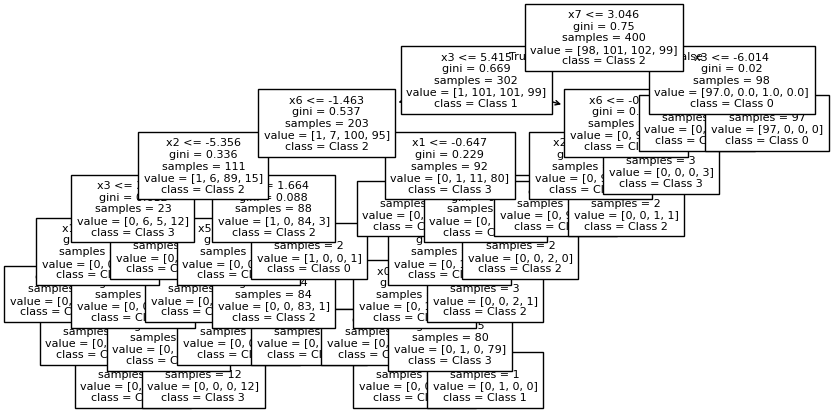

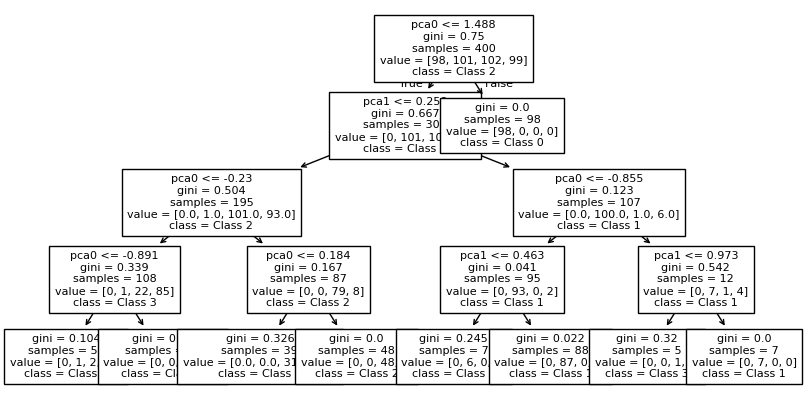

In [11]:
fig, ax = plt.subplots(1,1, figsize = (10, 5))
plot_tree(tree_clf,
          fontsize = 8,
          feature_names=X.columns,
          class_names = label_names,
          filled = False)
plt.show()

fig, ax = plt.subplots(1,1, figsize = (10, 5))
plot_tree(tree_clf2,
          fontsize = 8,
          feature_names=pca_cols,
          class_names = label_names,
          filled = False)
plt.show()

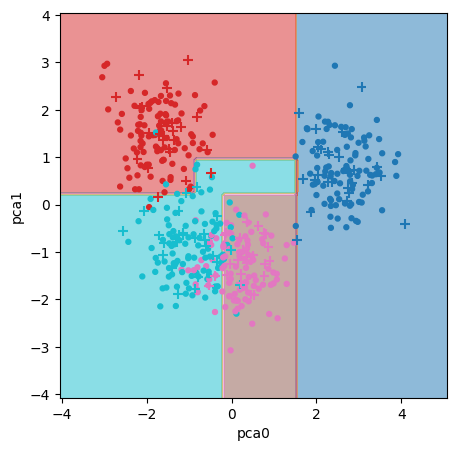

In [12]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
tree_boundaries2 = DecisionBoundaryDisplay.from_estimator(tree_clf2, X=P,
                                                         xlabel = 'pca0',
                                                         ylabel = 'pca1',
                                                         response_method = 'predict',
                                                         cmap = 'tab10', alpha = 0.5,
                                                         ax=ax)

ax.scatter(P_train[:,0], P_train[:,1], 
            c = y_train, cmap='tab10',
            marker = '.', s = 50, label = label_names)
ax.scatter(P_test[:,0], P_test[:,1], 
            c = y_test, cmap = 'tab10',
            marker = '+', s=50)

plt.show()

Decision trees dissect the feature space with horizontal and vertical lines. In the original data, the boundaries between groups are oriented on a diagonal; as a result, the decision tree creates a stair-step partition of the space.

The PCA-transformed data is oriented more vertically, allowing for more continuous and straight boundaries.

### Why/when to use PCA

 - *High-dimensional data*. Data with many features often require large models. PCA reduces the dimensionality of the data to allow simpler models. PCA can also be used to reduce the size of data, making it easier to store and handle.
 - *Informative features*. The new axes of the data are the most informative features.
 - *Colinearity*. If you have highly correlated features, they will be incorporated into a single principle component.
 - *Noisy data*. Noise in the data is often relegated to the later (less explanatory) principle components.